Inspired from Shilpi's code: https://github.com/Shilpi96/ilofar_stix_project/blob/main/nrh_analysis/create_nrh_image.py

In [420]:
# %matplotlib widget
# %matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import glob
from astropy.io import fits
from astropy import units as u 
from astropy.coordinates import SkyCoord
import sunpy.map
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from sunpy.net import Fido, attrs as a
from scipy.io import readsav
from sunpy.coordinates import frames
import numpy as np
import pandas as pd
from datetime import timedelta
from sunpy.time import parse_time
from astropy.visualization import ImageNormalize, SqrtStretch
from matplotlib import colors
from sunpy.coordinates import sun
from sunpy.sun import constants as const
import pfsspy
import pfsspy.tracing as tracing
from tqdm import tqdm
import os
import sys
# Construct the full path to the scripts directory
script_path = os.path.abspath('./scripts')

# Add the scripts directory to sys.path
if script_path not in sys.path:
    sys.path.append(script_path)

import importlib
import solar_data_utils as myfuncs
# Reload to update with new changes
importlib.reload(myfuncs)

seed_val = 7
import os
os.environ['PYTHONHASHSEED'] = str(seed_val)
import random
random.seed(seed_val)
import numpy as np
np.random.seed(seed_val)

plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.format'] = 'png'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

# set the directory path where the data is importe/stored
data_dir = '/home/mnedal/data'

In [153]:
pathdir = '/home/mnedal/data/nrh'

sav_files = sorted(glob.glob(f'{pathdir}/*.sav'))
print(*sav_files, sep='\n')

/home/mnedal/data/nrh/nrh_maps_210918_081800_083000_150_9.sav
/home/mnedal/data/nrh/nrh_maps_210918_081800_083000_173_2.sav
/home/mnedal/data/nrh/nrh_maps_210918_081800_083000_228_0.sav
/home/mnedal/data/nrh/nrh_maps_210918_081800_083000_298_7.sav
/home/mnedal/data/nrh/nrh_maps_210918_081800_083000_327_5.sav
/home/mnedal/data/nrh/nrh_maps_210918_081800_083000_408_0.sav
/home/mnedal/data/nrh/nrh_maps_210918_081800_083000_432_0.sav


In [252]:
# Read NRH data
filename = sav_files[5]
nrh = readsav(filename, python_dict=True)
# image_index = 0
# add 240 == 1 second
image_index = 0 + 240*2

# getting header info for a given time index
b = {name:nrh['nrh_hdr'][name][image_index] for name in nrh['nrh_hdr'].dtype.names}

# Constuct the NRH image
map_data = nrh['nrh_data'][image_index]

ref_coord = SkyCoord(0*u.arcsec, 0*u.arcsec, 
                     frame=frames.Helioprojective(observer='earth', obstime=b['DATE_OBS'])
                     )
header = sunpy.map.make_fitswcs_header(map_data,
                                       ref_coord,
                                       reference_pixel=[int(b['CRPIX1'])-1, int(b['CRPIX2'])-1]*u.pixel,
                                       scale=[float(b['CDELT1']), float(b['CDELT2'])]*u.arcsec/u.pixel,
                                       wavelength=float(b['FREQ'])*u.MHz)
nrh_map = sunpy.map.Map(map_data, header)

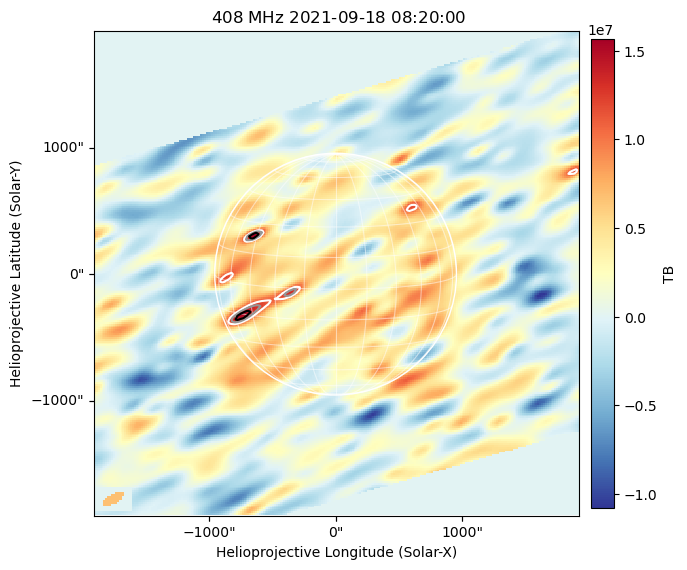

In [253]:
fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111, projection=nrh_map)
img = nrh_map.plot(axes=ax, cmap='RdYlBu_r') # viridis, plasma, inferno, jet, hsv_r, RdYlBu_r
nrh_map.draw_contours(axes=ax, levels=np.arange(70, 100, 10)*u.percent, cmap='Greys')
nrh_map.draw_limb(color='w')
nrh_map.draw_grid(color='w')
ax.grid(False)
fig.colorbar(img, pad=0.02, shrink=0.75, label=b['BUNIT'].decode('utf-8')) # Decode bytes to string using UTF-8 encoding
fig.tight_layout()
plt.show()

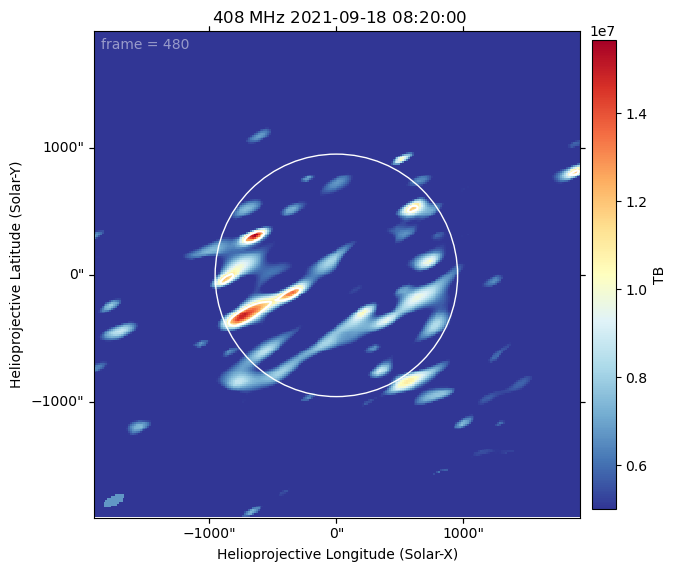

In [255]:
fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111, projection=nrh_map)
img = nrh_map.plot(axes=ax, vmin=0.5e7, cmap='RdYlBu_r')

with sunpy.coordinates.frames.Helioprojective.assume_spherical_screen(nrh_map.observer_coordinate):
    c0 = nrh_map.draw_contours(axes=ax, levels=70*u.percent, autoalign=True, cmap='Greys')

nrh_map.draw_limb(color='w')
ax.grid(False)
ax.text(3, nrh_map.data.shape[1]-10, f'frame = {image_index}', color='white', fontsize=10, alpha=0.5)
fig.colorbar(img, pad=0.02, shrink=0.75, label=b['BUNIT'].decode('utf-8'))
fig.tight_layout()
plt.show()

In [264]:
points0 = c0.allsegs[0][0]
# calc the centroid as the geometry mean of the contour shape; center of mass
centroid0 = points0.mean(axis=0)
# convert to arcsec unit
c_Arcsec = nrh_map.pixel_to_world(centroid0[0]*u.pix, centroid0[1]*u.pix)
print(f'{nrh_map.measurement}: x={c_Arcsec.Tx:.2f}, y={c_Arcsec.Ty:.2f}')

408.0 MHz: x=-684.59 arcsec, y=-298.15 arcsec


### Estimate the source size from the beam size approx.

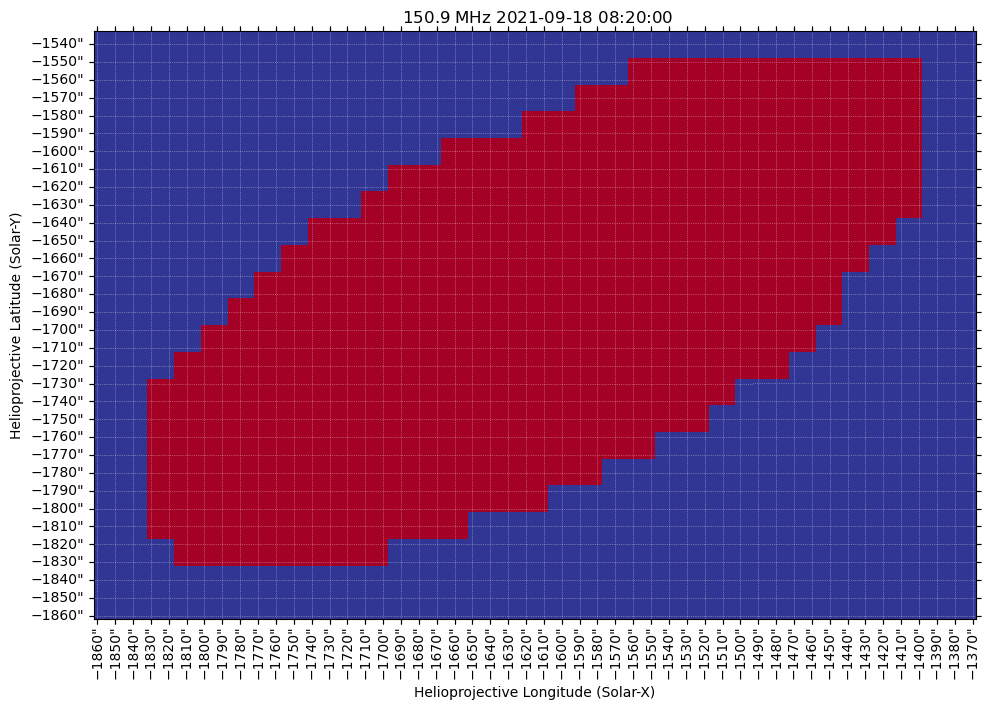

In [189]:
top_right   = SkyCoord(-1380*u.arcsec, -1540*u.arcsec, frame=nrh_map.coordinate_frame)
bottom_left = SkyCoord(-1860*u.arcsec, -1860*u.arcsec, frame=nrh_map.coordinate_frame)
nrh_submap = nrh_map.submap(bottom_left, top_right=top_right)

fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection=nrh_submap)
nrh_submap.plot(axes=ax, cmap='RdYlBu_r')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_ticks(spacing=10*u.arcsec)
lat.set_ticks(spacing=10*u.arcsec)
lon.set_ticklabel(rotation=90, pad=30)
fig.tight_layout()
plt.show()

In [185]:
# Est. major axis of the beam size @ NRH freqs
def calc_major_axis(x1=0, y1=0, x2=0, y2=0):
    length = np.sqrt( (x2-x1)**2 + (y2-y1)**2 )
    return length

In [304]:
# MAJOR AXES
major_axes_beams = {
    '150.9_MHz': {'x1':-1830,
                  'y1':-1810,
                  'x2':-1400,
                  'y2':-1550},
    '173.2_MHz': {'x1':-1810,
                  'y1':-1810,
                  'x2':-1450,
                  'y2':-1580},
    '228_MHz': {'x1':-1830,
                'y1':-1810,
                'x2':-1550,
                'y2':-1640},
    '298.7_MHz': {'x1':-1830,
                  'y1':-1830,
                  'x2':-1610,
                  'y2':-1700},
    '327.5_MHz': {'x1':-1820,
                  'y1':-1830,
                  'x2':-1622,
                  'y2':-1698},
    '408_MHz': {'x1':-1832,
                'y1':-1832,
                'x2':-1668,
                'y2':-1728},
    '432_MHz': {'x1':-1832,
                'y1':-1832,
                'x2':-1668,
                'y2':-1728}
}

# MINOR AXES
minor_axes_beams = {
    '150.9_MHz': {'x1':-1668,
                  'y1':-1608,
                  'x2':-1548,
                  'y2':-1772},
    '173.2_MHz': {'x1':-1682,
                  'y1':-1638,
                  'x2':-1562,
                  'y2':-1772},
    '228_MHz': {'x1':-1728,
                'y1':-1682,
                'x2':-1638,
                'y2':-1788},
    '298.7_MHz': {'x1':-1742,
                  'y1':-1728,
                  'x2':-1698,
                  'y2':-1801},
    '327.5_MHz': {'x1':-1742,
                  'y1':-1728,
                  'x2':-1682,
                  'y2':-1801},
    '408_MHz': {'x1':-1772,
                'y1':-1758,
                'x2':-1728,
                'y2':-1818},
    '432_MHz': {'x1':-1773,
                'y1':-1757,
                'x2':-1743,
                'y2':-1801}
}

beams = {'150.9_MHz': {'major_arcsec': [],
                       'minor_arcsec': [],
                      'Xs': [], 'Ys': []},
         '173.2_MHz': {'major_arcsec': [],
                       'minor_arcsec': [],
                       'Xs': [], 'Ys': []},
        '228_MHz': {'major_arcsec': [],
                    'minor_arcsec': [],
                    'Xs': [], 'Ys': []},
         '298.7_MHz': {'major_arcsec': [],
                       'minor_arcsec': [],
                       'Xs': [], 'Ys': []},
         '327.5_MHz': {'major_arcsec': [],
                       'minor_arcsec': [],
                       'Xs': [], 'Ys': []},
         '408_MHz': {'major_arcsec': [],
                     'minor_arcsec': [],
                     'Xs': [], 'Ys': []},
         '432_MHz': {'major_arcsec': [],
                    'minor_arcsec': [],
                     'Xs': [], 'Ys': []}
        }

In [211]:
# # Find the radius of the Sun in NRH images at different freqs
# for filename in sav_files:
#     # Read NRH data
#     nrh = readsav(filename, python_dict=True)
#     image_index = 0 + 240*2
#     # getting header info for a given time index
#     b = {name:nrh['nrh_hdr'][name][image_index] for name in nrh['nrh_hdr'].dtype.names}
#     # Constuct the NRH image
#     map_data = nrh['nrh_data'][image_index]
#     ref_coord = SkyCoord(0*u.arcsec, 0*u.arcsec, 
#                          frame=frames.Helioprojective(observer='earth', obstime=b['DATE_OBS'])
#                          )
#     header = sunpy.map.make_fitswcs_header(map_data,
#                                            ref_coord,
#                                            reference_pixel=[int(b['CRPIX1'])-1, int(b['CRPIX2'])-1]*u.pixel,
#                                            scale=[float(b['CDELT1']), float(b['CDELT2'])]*u.arcsec/u.pixel,
#                                            wavelength=float(b['FREQ'])*u.MHz)
#     nrh_map = sunpy.map.Map(map_data, header)
#     print(f'Sun radius in NRH image at {nrh_map.measurement}: {nrh_map.rsun_obs:.2f}')

### Major Axes

In [305]:
for key in major_axes_beams.keys():
    beams[key]['major_arcsec'] = calc_major_axis(
                                            x1=major_axes_beams[key]['x1'],
                                            y1=major_axes_beams[key]['y1'],
                                            x2=major_axes_beams[key]['x2'],
                                            y2=major_axes_beams[key]['y2']
                                        )
    beams[key]['major_rsun'] = beams[key]['major_arcsec']/954.66
    print(f"Major axis of beam at {key}: {beams[key]['major_rsun']:.2f} Rs")

Major axis of beam at 150.9_MHz: 0.53 Rs
Major axis of beam at 173.2_MHz: 0.45 Rs
Major axis of beam at 228_MHz: 0.34 Rs
Major axis of beam at 298.7_MHz: 0.27 Rs
Major axis of beam at 327.5_MHz: 0.25 Rs
Major axis of beam at 408_MHz: 0.20 Rs
Major axis of beam at 432_MHz: 0.20 Rs


### Minor Axes

In [306]:
for key in minor_axes_beams.keys():
    beams[key]['minor_arcsec'] = calc_major_axis(
                                            x1=minor_axes_beams[key]['x1'],
                                            y1=minor_axes_beams[key]['y1'],
                                            x2=minor_axes_beams[key]['x2'],
                                            y2=minor_axes_beams[key]['y2']
                                        )
    beams[key]['minor_rsun'] = beams[key]['minor_arcsec']/954.66
    print(f"Minor axis of beam at {key}: {beams[key]['minor_rsun']:.2f} Rs")

Minor axis of beam at 150.9_MHz: 0.21 Rs
Minor axis of beam at 173.2_MHz: 0.19 Rs
Minor axis of beam at 228_MHz: 0.15 Rs
Minor axis of beam at 298.7_MHz: 0.09 Rs
Minor axis of beam at 327.5_MHz: 0.10 Rs
Minor axis of beam at 408_MHz: 0.08 Rs
Minor axis of beam at 432_MHz: 0.06 Rs


### Est. sources' centroids

150.9 MHz: x=-865.16 arcsec, y=-1000.11 arcsec


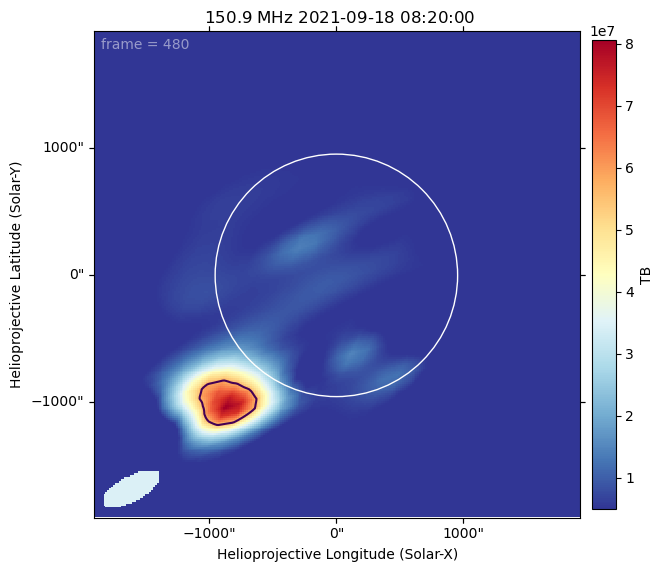

173.2 MHz: x=-828.89 arcsec, y=-945.24 arcsec


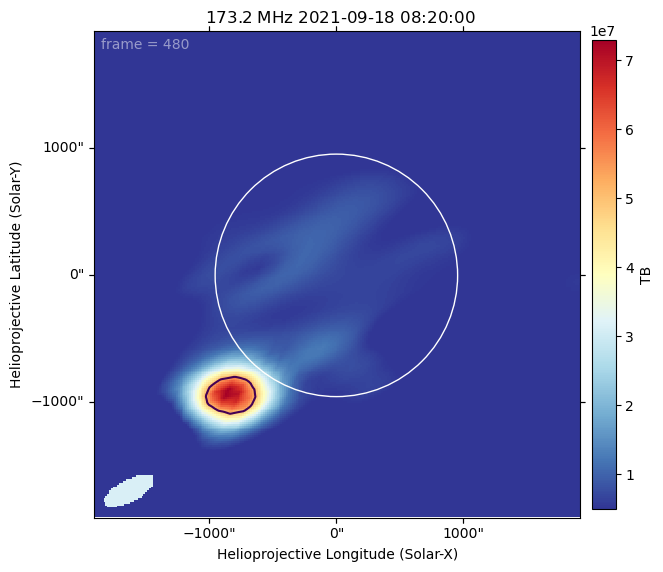

228.0 MHz: x=-795.39 arcsec, y=-902.26 arcsec


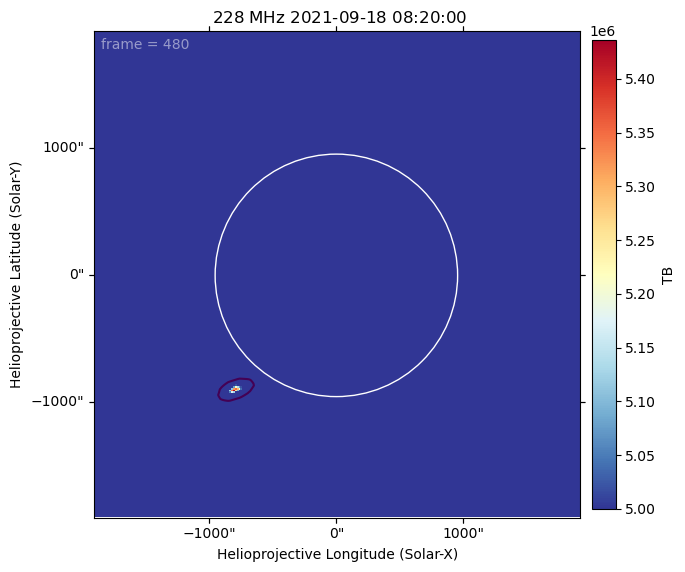

298.7 MHz: x=-743.28 arcsec, y=-860.22 arcsec


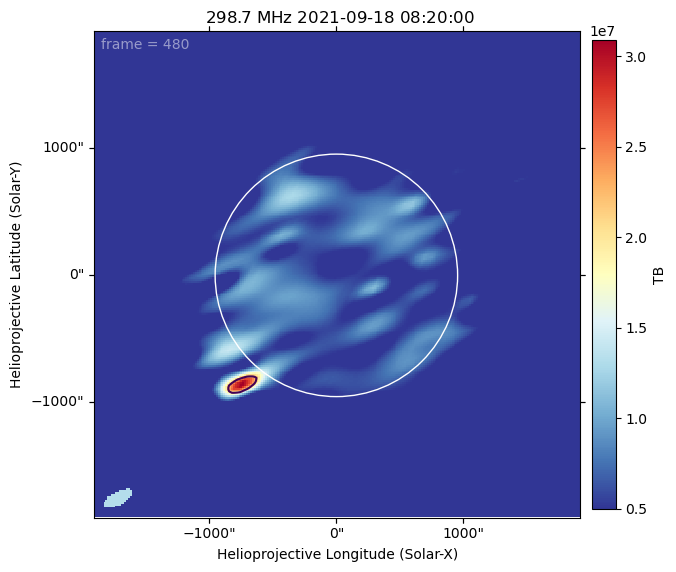

327.5 MHz: x=-746.01 arcsec, y=-841.60 arcsec


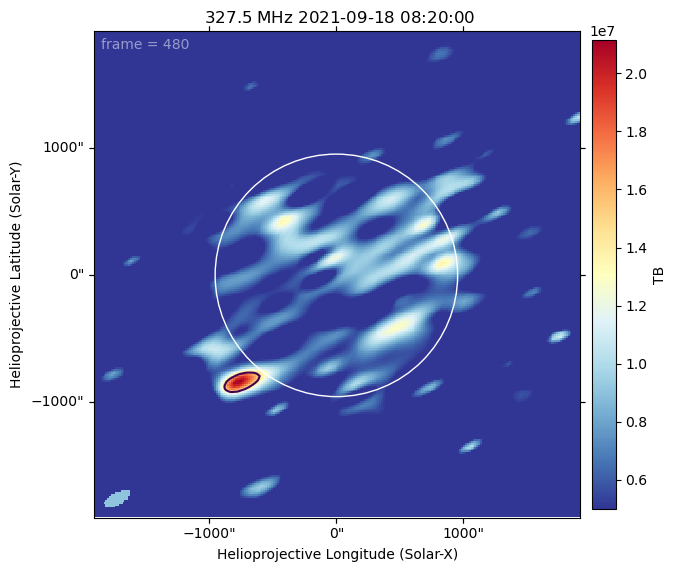

408.0 MHz: x=-684.59 arcsec, y=-298.15 arcsec


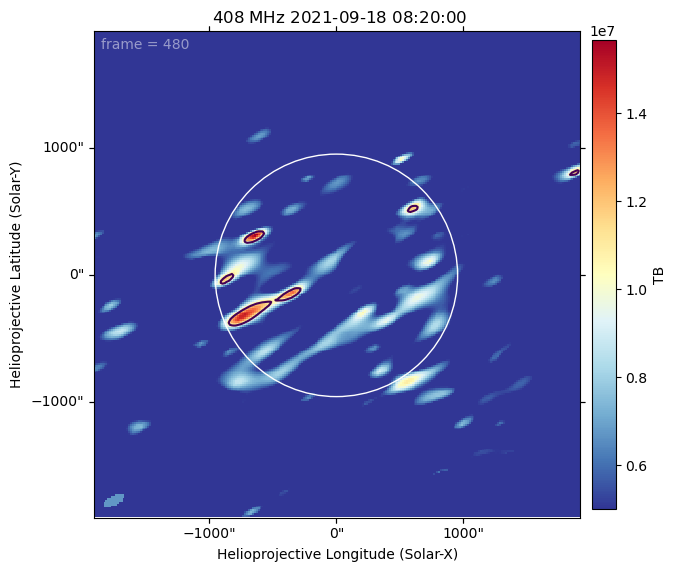

432.0 MHz: x=-652.29 arcsec, y=-224.97 arcsec


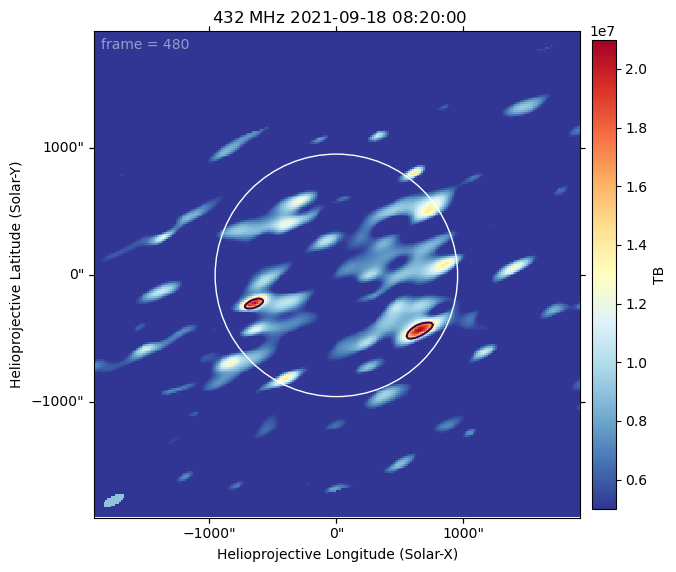

In [307]:
for key, filename in zip(beams.keys(), sav_files):
    # Read NRH data
    nrh = readsav(filename, python_dict=True)
    image_index = 0 + 240*2
    # getting header info for a given time index
    b = {name:nrh['nrh_hdr'][name][image_index] for name in nrh['nrh_hdr'].dtype.names}
    # Constuct the NRH image
    map_data = nrh['nrh_data'][image_index]
    ref_coord = SkyCoord(0*u.arcsec, 0*u.arcsec, 
                         frame=frames.Helioprojective(observer='earth', obstime=b['DATE_OBS'])
                         )
    header = sunpy.map.make_fitswcs_header(map_data,
                                           ref_coord,
                                           reference_pixel=[int(b['CRPIX1'])-1, int(b['CRPIX2'])-1]*u.pixel,
                                           scale=[float(b['CDELT1']), float(b['CDELT2'])]*u.arcsec/u.pixel,
                                           wavelength=float(b['FREQ'])*u.MHz)
    nrh_map = sunpy.map.Map(map_data, header)
    
    fig = plt.figure(figsize=[7,7])
    ax = fig.add_subplot(111, projection=nrh_map)
    img = nrh_map.plot(axes=ax, vmin=0.5e7, cmap='RdYlBu_r')
    with sunpy.coordinates.frames.Helioprojective.assume_spherical_screen(nrh_map.observer_coordinate):
        c0 = nrh_map.draw_contours(axes=ax, levels=70*u.percent, autoalign=True, color='black')

    if key == '408_MHz':
        points0 = c0.allsegs[0][0]  # pick the first centroid in the list
    else:
        points0 = c0.allsegs[0][-1] # pick the last centroid in the list
    # calc the centroid as the geometry mean of the contour shape; center of mass
    centroid0 = points0.mean(axis=0)
    # convert to arcsec unit
    c_Arcsec = nrh_map.pixel_to_world(centroid0[0]*u.pix, centroid0[1]*u.pix)
    print(f'{nrh_map.measurement}: x={c_Arcsec.Tx:.2f}, y={c_Arcsec.Ty:.2f}')
    beams[key]['Xs'] = c_Arcsec.Tx.value
    beams[key]['Ys'] = c_Arcsec.Ty.value
    nrh_map.draw_limb(color='w')
    ax.grid(False)
    ax.text(3, nrh_map.data.shape[1]-10, f'frame = {image_index}', color='white', fontsize=10, alpha=0.5)
    fig.colorbar(img, pad=0.02, shrink=0.75, label=b['BUNIT'].decode('utf-8'))
    fig.tight_layout()
    plt.show()

In [131]:
# print(f'Sun radius in NRH image: {nrh_map.rsun_obs:.2f}')
# print(f'Major axis of beam at {nrh_map.measurement}: {major:.2f}')
# print(f'\tin solar radius unit: {major.value/nrh_map.rsun_obs.value:.2f} Rs')

In [ ]:
# Load AIA map
start_time = pd.Timestamp(nrh_map.meta['date-obs'])
end_time   = pd.Timestamp(nrh_map.meta['date-obs']) + timedelta(minutes=1)

aia_map = myfuncs.load_aia_single(data_dir=data_dir, start=start_time, end=end_time, level=1, channel=193)[0]

In [ ]:
# Plot radio contours on AIA data
fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(121, projection=aia_map)
aia_map.plot(axes=ax)
ax.grid(False)

ax = fig.add_subplot(122, projection=aia_map)
aia_map.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=4e3, stretch=SqrtStretch())
aia_map.plot(axes=ax, cmap='Greys')
ax.grid(False)

fig.tight_layout()
plt.show()

In [112]:
with frames.Helioprojective.assume_spherical_screen(aia_map.observer_coordinate):
    nrh_map2 = nrh_map.reproject_to(aia_map.wcs)

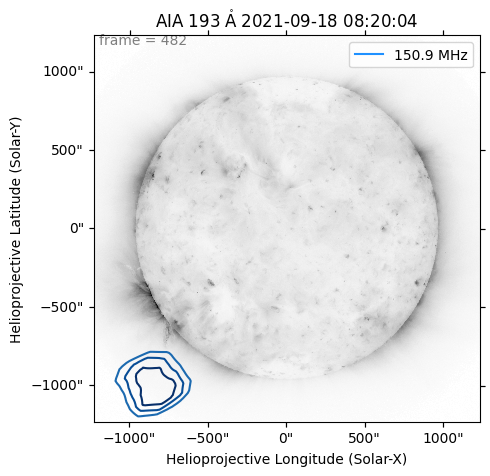

In [113]:
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(111, projection=aia_map)
aia_map.plot(axes=ax, cmap='Greys')
nrh_map2.draw_contours(axes=ax, levels=np.arange(70, 100, 10)*u.percent, cmap='Blues')
ax.text(50, aia_map.data.shape[1]-100, f'frame = {image_index}', color='black', fontsize=10, alpha=0.5)

# Make a proxy artist for the legend
contour_legend = mlines.Line2D([], [], color='dodgerblue', label=f"{nrh_map.meta['wavelnth']} MHz")
ax.legend(handles=[contour_legend])
ax.grid(False)
fig.tight_layout()
plt.show()

In [87]:
import matplotlib.cm as cm

# Define the colormaps you want to use
# colormaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlGnBu']
colormaps = ['YlGnBu', 'Reds', 'Oranges', 'Greens', 'Blues', 'Purples', 'Greys']

# Choose a value to sample from the colormap (0.5 is the middle)
sample_value = 0.5

# Create a dictionary to store the selected colors
selected_colors = {}

for cmap_name in colormaps:
    cmap = cm.get_cmap(cmap_name)   # Get the colormap object
    color = cmap(sample_value)      # Sample the color at the middle point
    selected_colors[cmap_name] = color

# # Display the selected colors
# for cmap_name, color in selected_colors.items():
#     print(f"{cmap_name}: {color}")

YlGnBu: (0.2526874279123414, 0.7114494425221068, 0.7683813917723953, 1.0)
Reds: (0.9835755478662053, 0.4127950788158401, 0.28835063437139563, 1.0)
Oranges: (0.9914186851211073, 0.550726643598616, 0.23277201076509035, 1.0)
Greens: (0.45176470588235296, 0.7670895809304115, 0.4612072279892349, 1.0)
Blues: (0.41708573625528644, 0.6806305267204922, 0.8382314494425221, 1.0)
Purples: (0.617762399077278, 0.6021376393694733, 0.7834525182622069, 1.0)
Greys: (0.586082276047674, 0.586082276047674, 0.586082276047674, 1.0)


Loading NRH maps ...: 100%|███████████████████████████████████| 7/7 [15:34<00:00, 133.55s/it]


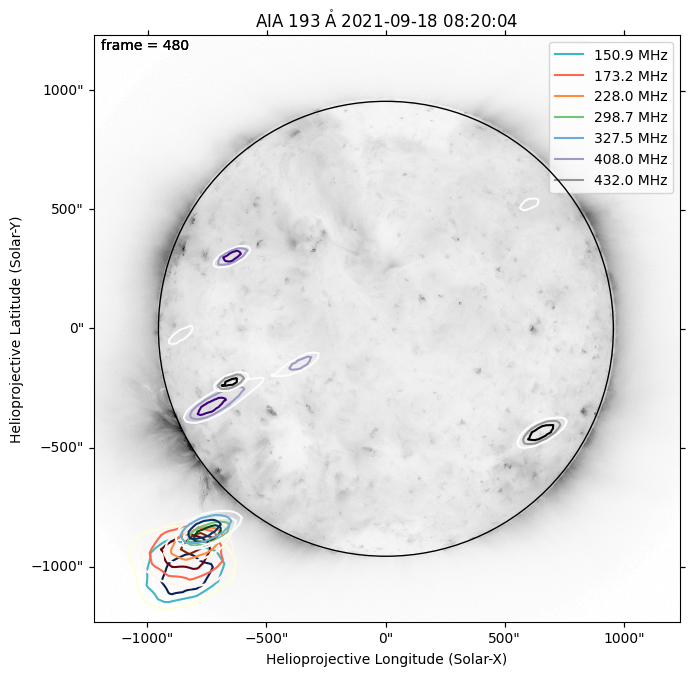

In [96]:
# Plot the contours of all frequencies of NRH on AIA map
fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111, projection=aia_map)
aia_map.plot(axes=ax, cmap='Greys')
ax.text(50, aia_map.data.shape[1]-100, f'frame = {image_index}', color='black', fontsize=10, alpha=0.5)

handles = []

# Read NRH data
with tqdm(total=len(sav_files), desc='Loading NRH maps ...') as pbar:
    for i, filename in enumerate(sav_files):
        nrh = readsav(filename, python_dict=True)
        # add 240 == 1 second
        image_index = 0 + 240
        
        # getting header info for a given time index
        b = {name:nrh['nrh_hdr'][name][image_index] for name in nrh['nrh_hdr'].dtype.names}
        
        # Constuct the NRH image
        map_data = nrh['nrh_data'][image_index]
        
        ref_coord = SkyCoord(0*u.arcsec, 0*u.arcsec, 
                             frame=frames.Helioprojective(observer='earth', obstime=b['DATE_OBS'])
                             )
        header = sunpy.map.make_fitswcs_header(map_data,
                                               ref_coord,
                                               reference_pixel=[int(b['CRPIX1'])-1, int(b['CRPIX2'])-1]*u.pixel,
                                               scale=[float(b['CDELT1']), float(b['CDELT2'])]*u.arcsec/u.pixel,
                                               wavelength=float(b['FREQ'])*u.MHz)
        nrh_map = sunpy.map.Map(map_data, header)
        
        with frames.Helioprojective.assume_spherical_screen(aia_map.observer_coordinate):
            nrh_map2 = nrh_map.reproject_to(aia_map.wcs)
        
        nrh_map2.draw_contours(axes=ax, levels=np.arange(70, 100, 10)*u.percent, cmap=colormaps[i])
        
        # Make a proxy artist for the legend
        contour_legend = mlines.Line2D([], [], color=selected_colors[colormaps[i]], label=f"{nrh_map.meta['wavelnth']} MHz")
        handles.append(contour_legend)
        pbar.update(1)

# aia_map.draw_limb(color='k')
ax.grid(False)
ax.legend(handles=handles)
fig.tight_layout()
plt.show()

In [83]:
# fig = plt.figure(figsize=[7,7])
# ax = fig.add_subplot(111, projection=aia_map)
# aia_map.plot(axes=ax, cmap='Greys')
# c0 = nrh_map2.draw_contours(axes=ax, levels=np.arange(70, 100, 10)*u.percent, cmap='Blues')

# # # calc the centroid as the geometry mean of the contour shape, center of mass
# # points0 = c0.allsegs[0][0]
# # centroid0 = points0.mean(axis=0)

# # # convert to arcsec unit
# # c_Arcsec = aia_map.pixel_to_world(centroid0[0]*u.pix, centroid0[1]*u.pix)
# # ax.plot_coord(c_Arcsec, color='r', marker='o', markersize=5, label=f"{nrh_map.meta['wavelnth']} MHz")

# # ax.legend(title='Centroids', loc='upper right')
# ax.legend(loc='upper right')
# ax.grid(False)
# fig.tight_layout()
# plt.show()

In [84]:
# aia_map.plot_settings['norm'] = colors.Normalize(vmin=0, vmax=350)

In [4]:
# print(len(nrh['nrh_data']))

In [5]:
# nrh['nrh_hdr'][0:len(nrh['nrh_data']):4]['DATE_OBS']

In [6]:
# len(nrh['nrh_hdr'][0:len(nrh['nrh_data']):4]['DATE_OBS'])

In [134]:
# Calculate the number of rows
n = len(nrh['nrh_hdr'][0:len(nrh['nrh_data']):4])
images_per_row = 4
rows = int(np.ceil(n / images_per_row))
print(n, rows)

fig = plt.figure(figsize=[18,5*rows])

# one image every one second
for i in range(len(nrh['nrh_hdr'][0:len(nrh['nrh_data']):4])):
    ax = plt.subplot(rows, images_per_row, i+1, projection=nrh_map)
    
    # get header info for a given time index
    b = {name:nrh['nrh_hdr'][name][i] for name in nrh['nrh_hdr'].dtype.names}
    
    # Constuct the NRH image
    map_data = nrh['nrh_data'][i]
    
    ref_coord = SkyCoord(0*u.arcsec, 0*u.arcsec, 
                         frame=frames.Helioprojective(observer='earth', obstime=b['DATE_OBS'])
                         )
    header = sunpy.map.make_fitswcs_header(map_data,
                                           ref_coord,
                                           reference_pixel=[int(b['CRPIX1'])-1, int(b['CRPIX2'])-1]*u.pixel,
                                           scale=[float(b['CDELT1']), float(b['CDELT2'])]*u.arcsec/u.pixel,
                                           wavelength=float(b['FREQ'])*u.MHz)
    nrh_map = sunpy.map.Map(map_data, header)
    
    # Show the map
    img = nrh_map.plot(axes=ax, cmap='RdYlBu_r') # viridis, plasma, inferno, jet, hsv_r, RdYlBu_r
    nrh_map.draw_limb(color='w')
    ax.grid(False)
    fig.colorbar(img, pad=0.02, shrink=0.75, label=b['BUNIT'].decode('utf-8')) # Decode bytes to string using UTF-8 encoding
    
fig.tight_layout()
plt.show()

721 181


### Export PNG images

In [46]:
nrh_maps = []
# headers_list = []
# images_list  = []

with tqdm(total=len(nrh['nrh_hdr']), desc='Loading NRH maps ...') as pbar:
    for i in range(len(nrh['nrh_hdr'])):
        b = {name:nrh['nrh_hdr'][name][i] for name in nrh['nrh_hdr'].dtype.names}
        m = nrh['nrh_data'][i]
        # headers_list.append(b)
        # images_list.append(m)
        ref_coord = SkyCoord(0*u.arcsec, 0*u.arcsec, 
                    frame=frames.Helioprojective(observer='earth', obstime=b['DATE_OBS'])
                    )
        header = sunpy.map.make_fitswcs_header(m,
                                               ref_coord,
                                               reference_pixel=[int(b['CRPIX1'])-1, int(b['CRPIX2'])-1]*u.pixel,
                                               scale=[float(b['CDELT1']), float(b['CDELT2'])]*u.arcsec/u.pixel,
                                               wavelength=float(b['FREQ'])*u.MHz)
        nrh_map = sunpy.map.Map(m, header)
        nrh_maps.append(nrh_map)
        pbar.update(1)

os.makedirs(f"{savedir}/png/nrh/{nrh_map.meta['wavelnth']}MHz", exist_ok=True)

Loading NRH maps ...: 100%|██████████████████████████████| 2881/2881 [01:11<00:00, 40.40it/s]


In [47]:
with tqdm(total=len(nrh_maps), desc='Exporting NRH images ...') as pbar:
    for i, m in enumerate(nrh_maps):
        output_filename = f"{savedir}/png/nrh/{m.meta['wavelnth']}MHz/{m.meta['date-obs']}_{m.meta['wavelnth']}{m.meta['waveunit']}.png"
        if not os.path.exists(output_filename):
            fig = plt.figure(figsize=[7,7])
            ax = fig.add_subplot(111, projection=m)
            img = m.plot(axes=ax,
                         # vmin=0.5e7,
                         vmin=0.5e6,
                         cmap='RdYlBu_r')
            m.draw_contours(axes=ax, levels=np.arange(70, 100, 10)*u.percent, cmap='Greys')
            m.draw_limb(color='w')
            ax.grid(False)
            ax.text(3, nrh_map.data.shape[1]-10, f'frame = {i}', color='white', fontsize=10, alpha=0.5)
            ax.set_title(f"{m.meta['wavelnth']} {m.meta['waveunit']} {m.meta['date-obs'].replace('T',' ')}")
            fig.colorbar(img, pad=0.02, shrink=0.75, label=b['BUNIT'].decode('utf-8'))
            fig.tight_layout()
            fig.savefig(output_filename, dpi=100, bbox_inches='tight')
            plt.close()
            pbar.update(1)

Exporting NRH images ...: 100%|████████████████████████| 2881/2881 [1:00:04<00:00,  1.25s/it]


Plot all images and make animation

Export each image individually

In [16]:
pathdir = r'D:\Study\Academic\Research\PostDoc_work\DIAS_Fellowship_2024\Work\plots\nrh'
for i, nrh_map in enumerate(nrh_maps[1253:]):
    fig = plt.figure(figsize=[7,7])
    ax = fig.add_subplot(111, projection=nrh_map)
    img = nrh_map.plot(axes=ax, cmap='jet')
    nrh_map.draw_limb(color='w')
    nrh_map.draw_grid(color='w')
    fig.colorbar(img, pad=0.02, shrink=0.75, label=b['BUNIT'].decode('utf-8'))
    fig.tight_layout()
    fig.savefig(f"{pathdir}/{nrh_map.meta['wavelnth']}_{nrh_map.meta['waveunit']}_{nrh_map.meta['date-obs'].replace(':','_')}.png",
                format='png', dpi=100, bbox_inches='tight')
    plt.close()
    print(f"{nrh_map.meta['date-obs']} has been exported.")

2021-09-18T08:23:13.450 has been exported.
2021-09-18T08:23:13.700 has been exported.
2021-09-18T08:23:13.950 has been exported.
2021-09-18T08:23:14.200 has been exported.
2021-09-18T08:23:14.450 has been exported.
2021-09-18T08:23:14.700 has been exported.
2021-09-18T08:23:14.950 has been exported.
2021-09-18T08:23:15.200 has been exported.
2021-09-18T08:23:15.450 has been exported.
2021-09-18T08:23:15.700 has been exported.
2021-09-18T08:23:15.950 has been exported.
2021-09-18T08:23:16.200 has been exported.
2021-09-18T08:23:16.450 has been exported.
2021-09-18T08:23:16.700 has been exported.
2021-09-18T08:23:16.950 has been exported.
2021-09-18T08:23:17.200 has been exported.
2021-09-18T08:23:17.450 has been exported.
2021-09-18T08:23:17.700 has been exported.
2021-09-18T08:23:17.950 has been exported.
2021-09-18T08:23:18.200 has been exported.
2021-09-18T08:23:18.450 has been exported.
2021-09-18T08:23:18.700 has been exported.
2021-09-18T08:23:18.950 has been exported.
2021-09-18T

KeyboardInterrupt: 